In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, train_test_split, RandomizedSearchCV, validation_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import plot_roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import FeatureAgglomeration

from category_encoders import TargetEncoder, WOEEncoder




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Task 1 Classification on the ‘credit-g’ dataset (40 points)
### You can download the dataset with ‘fetch_openml(‘credit_g’)’ and see it’s description at https://www.openml.org/d/31
#### 1.1 Determine which features are continuous and which are categorical.
#### 1.2 Visualize the univariate distribution of each continuous feature, and the distribution of the target.
#### 1.3 Split data into training and test set. Do not use the test set until a final evaluation in 1.5.
#### Preprocess the data (such as treatment of categorical variables) without using a pipeline and evaluate an initial LogisticRegression model with an training/validation split.
#### 1.4 Use ColumnTransformer and pipeline to encode categorical variables (your choice of OneHotEncoder or another one from the categorical_encoder package, or both). Evaluate Logistic Regression, linear support vector machines and nearest neighbors usingcross-validation. How different are the results? How does scaling the continuous features with StandardScaler influence the results?
#### 1.5 Tune the parameters using GridSearchCV. Do the results improve? Evaluate only the be model on the test set. Visualize the performance as function of the parameters for all three models.
#### 1.6 Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do the parameters that are found change? Do they change if you change the random seed of the shuffling? Or if you change the random state of the split into training and test data?
##### 1.7 Visualize the 20 most important coefficients for LogisticRegression and Linear Support Vector Machines using hyper-parameters that performed well in the grid-search.

In [0]:
def _get_model_name(model):
    """
        Returns a string with the name of a sklearn model
            model: Sklearn stimator class
    """
    if isinstance(model, Pipeline):
        estimator = model.steps[-1][1]
        name = "Pipeline_" + str(estimator)[:str(estimator).find("(")]
    else: 
        name = str(model)[:str(model).find("(")]
    return name 

def plot_cv_score(X, y, models_list, cv = 5, scoring = None, refit = True):
    """ 
        X: numpy_array/pandas dataframe n_rows, m_features
        y: numpy_array/pandas dataframe n_rows
        Plots min, max and avg kfold crosval_score for a list of models
    
    """

    
    
    names, scores, min_score, max_score, mean_score = list(), list(), list(), list(), list()

    for model in models_list:
        name = _get_model_name(model)
        names.append(name)

        if refit:
            model.fit(X, y)
        
        score = cross_val_score(model, X, y, cv = cv, scoring = scoring, n_jobs= -1)

        min_score.append(np.min(score))
        max_score.append(np.max(score))
        mean_score.append(np.mean(score))
        scores.append(score)
    
    frame_summary = pd.DataFrame({'Min':min_score, 'Average': mean_score, 'Max': max_score,}, index = names).sort_values(by = 'Average')

    frame_scores = pd.DataFrame(np.vstack(scores).T, columns = names) 


    fig, ax  = plt.subplots(1,2, figsize = (15,7))

    frame_summary.plot.barh(edgecolor = 'black', ax = ax[0], cmap = 'RdYlBu')
    ax[0].legend(loc = 'best')
    ax[0].set_xlabel("Score")

    frame_scores.boxplot(ax = ax[1])
    ax[1].set_title("Model scores distribution")
    ax[1].set_ylabel("Score")
    ax[1].tick_params(labelrotation=90)

In [0]:
def optimize_parameters(model, param_dict, X, y, cv = None, metric = None, random_state = 1990):
    """
    Performs a cross validation strategy to find the best set of parameters from param_dict
    """

    grid = RandomizedSearchCV(estimator= model,
                              param_distributions= param_dict,
                              scoring = metric,
                              cv = cv,
                              random_state= random_state,
                              n_jobs= -1,
                              return_train_score= True).fit(X, y)
    
    return grid

In [0]:
def plot_validation_curve(model, X, y, param_name, param_range, metric = None, cv = None):

    train_scores, test_scores = validation_curve(
        model, X, y, param_name= param_name, param_range = param_range,
        scoring= metric, cv = cv, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                color="red", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2,
                    color="red", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2,
                    color="navy", lw=lw)
    plt.legend(loc="best")

In [0]:
data = pd.read_csv("dataset_31_credit-g.csv")

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13  other_payment_plans     1000 non-null   object
 14  housing                 1000 non-null   object
 15  exist

In [7]:
data.sample(7)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
842,'no checking',18,'existing paid',repairs,1943,'<100','<1',4,'female div/dep/mar',none,4,'real estate',23,none,own,1,skilled,1,none,yes,bad
992,'<0',18,'existing paid',radio/tv,1936,'no known savings','4<=X<7',2,'male mar/wid',none,4,car,23,none,rent,2,'unskilled resident',1,none,yes,good
665,'no checking',24,'critical/other existing credit',other,6314,'<100',unemployed,4,'male single','co applicant',2,'no known property',27,bank,own,2,'high qualif/self emp/mgmt',1,yes,yes,good
758,'no checking',24,'existing paid','new car',1393,'<100','1<=X<4',2,'male single',guarantor,2,'real estate',31,none,own,1,skilled,1,yes,yes,good
218,'<0',24,'existing paid',furniture/equipment,3021,'<100','1<=X<4',2,'male div/sep',none,2,'real estate',24,none,rent,1,'unskilled resident',1,none,yes,good
754,'no checking',12,'delayed previously',repairs,1555,'>=1000','>=7',4,'male single',none,4,'no known property',55,none,'for free',2,skilled,2,none,yes,bad
925,'<0',12,'all paid','new car',697,'<100','<1',4,'male single',none,2,car,46,bank,own,2,skilled,1,yes,yes,bad


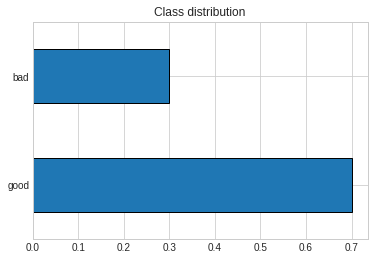

In [8]:
data["class"].value_counts(True).plot.barh(edgecolor = "black")
plt.title("Class distribution");

1.1 Determine which features are continuous and which are categorical.

In [9]:
# categorical features
data.select_dtypes(include = "object").columns.tolist()

['checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'personal_status',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'job',
 'own_telephone',
 'foreign_worker',
 'class']

In [10]:
# continuous features
data.select_dtypes(exclude = "object").columns.tolist()

['duration',
 'credit_amount',
 'installment_commitment',
 'residence_since',
 'age',
 'existing_credits',
 'num_dependents']

1.2 Visualize the univariate distribution of each continuous feature, and the distribution of the target.

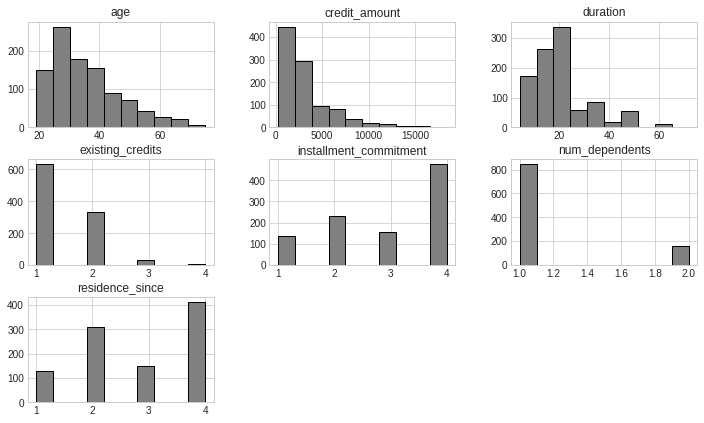

In [11]:
data.hist(edgecolor = 'black', color = 'grey', figsize = (12,7));

1.3 Split data into training and test set. Do not use the test set until a final evaluation in 1.5. Preprocess the data (such as treatment of categorical variables)  and evaluate an initial LogisticRegression model with an training/validation split.

In [0]:
X_train, X_val, y_train, y_val = train_test_split(data.drop(["class"], axis = 1), data["class"].map({"good":1,"bad":-1}), test_size = .4, random_state = 1990)

In [0]:
categorical = X_train.select_dtypes(include = "object").columns.tolist()
continuous = X_train.select_dtypes(exclude = "object").columns.tolist()

In [0]:
preprocesor = make_column_transformer((TargetEncoder(),categorical), (StandardScaler(), continuous))

In [0]:
pipe = make_pipeline(preprocesor, LogisticRegression(class_weight= "balanced")).fit(X_train, y_train)

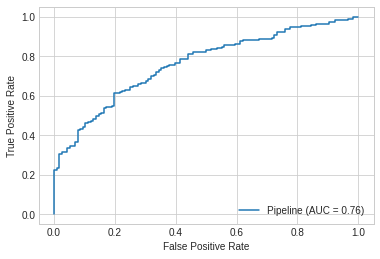

In [16]:
plot_roc_curve(pipe, X_val, y_val);

1.4 Use ColumnTransformer and pipeline to encode categorical variables (your choice of OneHotEncoder or another one from the categorical_encoder package, or both). Evaluate Logistic Regression, linear support vector machines and nearest neighbors usingcross-validation. How different are the results? How does scaling the continuous features with StandardScaler influence the results?

#### Scaled variables

In [0]:
preprocesor = make_column_transformer((TargetEncoder(),categorical), (StandardScaler(), continuous))
models = [make_pipeline(preprocesor, LogisticRegression(class_weight= "balanced")),
          make_pipeline(preprocesor, SVC(class_weight= "balanced", probability= True)),
          make_pipeline(preprocesor, KNeighborsClassifier(weights= "distance"))]

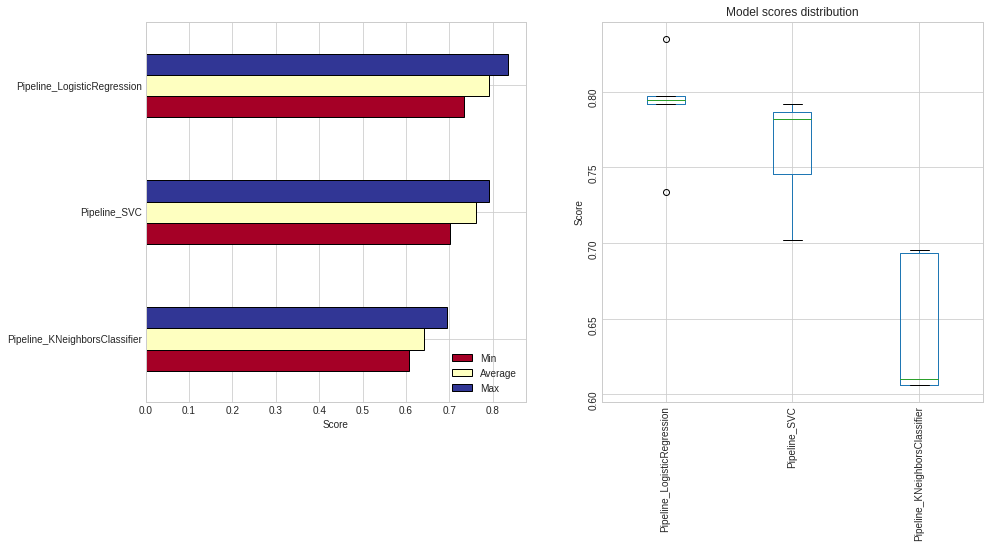

In [18]:
plot_cv_score(X_train, y_train, models, scoring= "roc_auc")

#### Non scaled variables

In [0]:
preprocesor = make_column_transformer((TargetEncoder(),categorical), remainder = "passthrough")
models = [make_pipeline(preprocesor, LogisticRegression(class_weight= "balanced")),
          make_pipeline(preprocesor, SVC(class_weight= "balanced", probability= True)),
          make_pipeline(preprocesor, KNeighborsClassifier(weights= "distance"))]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


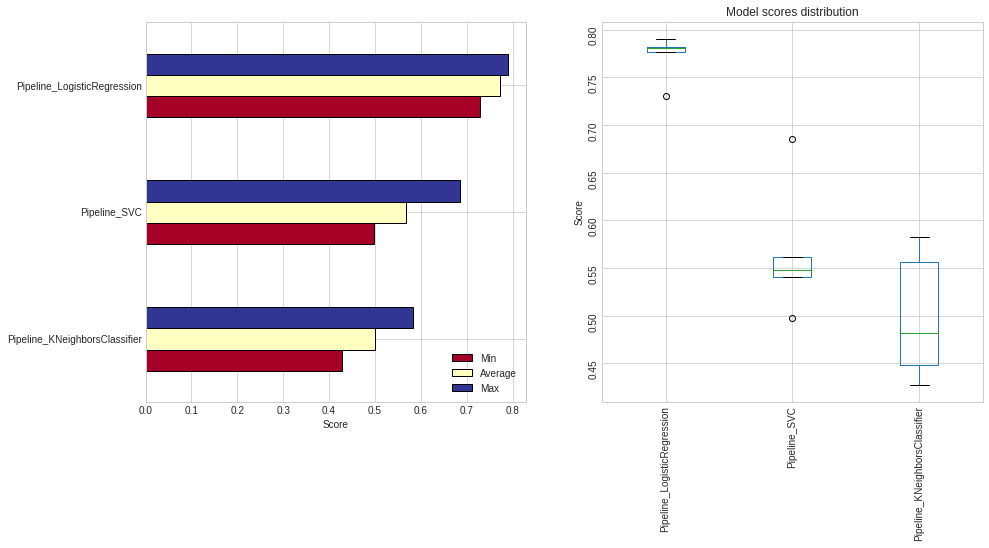

In [20]:
# the effect on no scaling the data was first a decreased on performace for each model and for Logistic regression the algorithm not even converged
plot_cv_score(X_train, y_train, models, scoring= "roc_auc")

1.5 Tune the parameters using GridSearchCV. Do the results improve? Evaluate only the be model on the test set. Visualize the performance as function of the parameters for all three models.
1.6 Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do the parameters that are found change? Do they change if you change the random seed of the shuffling? Or if you change the random state of the split into training and test data?

In [0]:
preprocesor = make_column_transformer((TargetEncoder(),categorical), (StandardScaler(), continuous))

modelOne = Pipeline([("preprocesor",preprocesor), ("model",LogisticRegression(max_iter = 10000))])
param_dict = {"model__C":np.logspace(-2.5,2.5,10)}
LogReg = optimize_parameters(modelOne, param_dict,X_train, y_train, cv = 7, metric = "roc_auc")

In [22]:
LogReg.best_estimator_.score(X_val, y_val)

0.7325

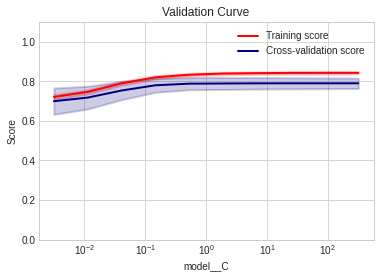

In [23]:
plot_validation_curve(modelOne, X_train, y_train, "model__C", np.logspace(-2.5,2.5,10), "roc_auc")

In [0]:
preprocesor = make_column_transformer((TargetEncoder(),categorical), (StandardScaler(), continuous))

modelTwo = Pipeline([("preprocesor",preprocesor), ("model",SVC())])
param_dict = {"model__C":np.logspace(-2.5,2.5,10),
              "model__gamma":["scale", "auto"],
              "model__kernel":["linear", "rbf", "poly"]}
SVM = optimize_parameters(modelTwo, param_dict,X_train, y_train, cv = 7, metric = "roc_auc")

In [25]:
SVM.best_estimator_.score(X_val, y_val)

0.745

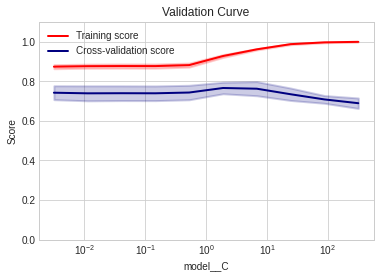

In [26]:
plot_validation_curve(modelTwo, X_train, y_train, "model__C", np.logspace(-2.5,2.5,10), "roc_auc")

In [0]:
preprocesor = make_column_transformer((TargetEncoder(),categorical), (StandardScaler(), continuous))

modelThree = Pipeline([("preprocesor",preprocesor), ("model",KNeighborsClassifier())])
param_dict = {"model__n_neighbors":np.arange(30,60,2)}
Knn = optimize_parameters(modelThree, param_dict,X_train, y_train, cv = 7, metric = "roc_auc")

In [28]:
Knn.best_estimator_.score(X_val, y_val)

0.7125

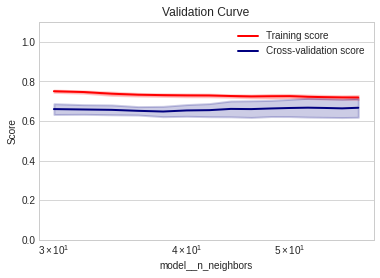

In [29]:
plot_validation_curve(modelThree, X_train, y_train, "model__n_neighbors", np.arange(30,60,2), "roc_auc")

1.7 Visualize the 20 most important coefficients for LogisticRegression and Linear Support Vector Machines using hyper-parameters that performed well in the grid-search

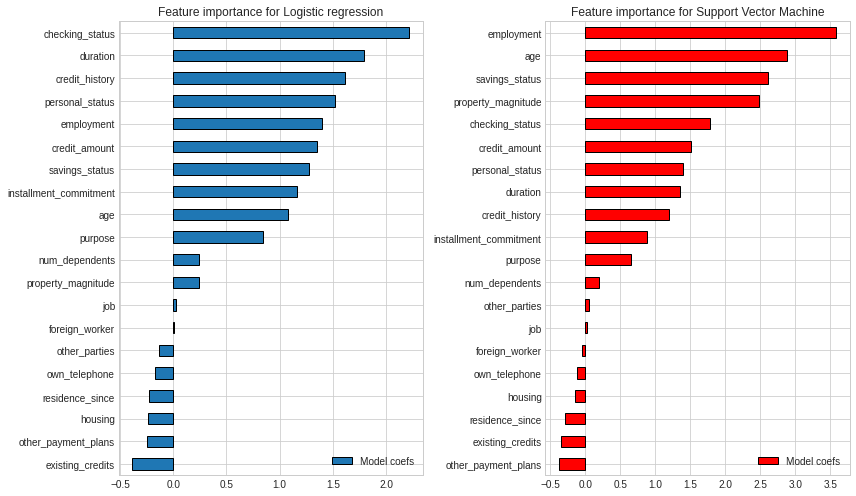

In [30]:
fig, ax = plt.subplots(1,2, figsize = (12,7))
pd.DataFrame({"Model coefs":LogReg.best_estimator_["model"].coef_[0]},
             index = X_train.columns).sort_values(by = "Model coefs").plot.barh(edgecolor = "black", ax = ax[0])
ax[0].set_title("Feature importance for Logistic regression")

pd.DataFrame({"Model coefs":SVM.best_estimator_["model"].coef_[0]},
             index = X_train.columns).sort_values(by = "Model coefs").plot.barh(edgecolor = "black", color = "red", ax = ax[1])
ax[1].set_title("Feature importance for Support Vector Machine")
plt.tight_layout();